In [ ]:
linear fusion through weights changing

no saved model

In [22]:
# ------no training -----
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from sensorFusionDataset.creatDataset_2_encoder import CreateDatasets
from sensorFusionDataset.data_split import split_dataset
from sensorFusionNetwork.simpleAutoencoder_compress import SimpleAutoencoder
from testLoop import test_loop
from trainLoop import train_loop
from visualization import plot_losses, plot_metrics,plotTraining
from earlystopping import EarlyStopping

import h5py as h5
from datetime import datetime
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import time

# local_time =time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[-8:-1]
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
# CPU OR GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

damage_severity = '8'
damaged_img_path = 'deepEmsemblesDataset/Salt/damaged_image_{}'.format(damage_severity) 


lidar_path = 'deepEmsemblesDataset/lidar_tensor'



label_path = 'deepEmsemblesDataset/ori_image'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))
lidar_list = sorted(glob.glob(lidar_path + '/*'))
label_list = sorted(glob.glob(label_path + '/*'))

learning_rate = 1e-4
batch_size = 32

TestDataset = CreateDatasets(label_list, damaged_img_list, lidar_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

print (f'loading fertig! {device}' )

loading fertig! cuda


In [2]:
# no retraining
# loading model sparse & FIX
removal_layer = nn.Sequential()

hidden_img_list = []
hidden_lidar_list = []

for i in range(1,11):
    encoder_img = SimpleAutoencoder()
    encoder_img.load_state_dict(torch.load(f'model_save/fusion_5/compressed_encoder/ori2ori_{i}.pth'))
    encoder_img.decoder = removal_layer


    encoder_lidar = SimpleAutoencoder()
    encoder_lidar.load_state_dict(torch.load(f'model_save/fusion_5/compressed_encoder/lidar2img_{i}.pth'))
    encoder_lidar.decoder = removal_layer

    encoder_img.eval()
    encoder_lidar.eval()

    # obtain one batch of test images
    dataiter = iter(new_testloader)
    label, damaged_img, lidar = next(dataiter)


    # fusion and output
    hidden_img = encoder_img(damaged_img)
    hidden_lidar = encoder_lidar(lidar)
    print(hidden_img.shape)
    hidden_img_list.append(hidden_img)
    hidden_lidar_list.append(hidden_lidar)


# print(hidden_img_list[0].shape) --> torch.Size([32, 64, 50, 50])

    
stacked_img = torch.stack(hidden_img_list, dim=0)

# print(stacked_img.shape) --> torch.Size([10, 32, 64, 50, 50])

# print(stacked_img[:,0,0,0,0])

stacked_lidar =  torch.stack(hidden_lidar_list, dim=0)

hidden_img_mean = torch.mean(stacked_img, dim=0)
hidden_lidar_mean = torch.mean(stacked_lidar, dim=0)
hidden_img_std = torch.std(stacked_img, dim=0)

# print(hidden_img_std[0,0,0,0])

hidden_lidar_std = torch.std(stacked_lidar, dim=0)

# print(torch.sum(hidden_img_std),torch.sum(hidden_lidar_std))

# tensor(27447.9961, grad_fn=<SumBackward0>) tensor(1601346.2500, grad_fn=<SumBackward0>)
# tensor(25380.6328, grad_fn=<SumBackward0>) tensor(1601346.2500, grad_fn=<SumBackward0>)


# Save hidden_img_mean
torch.save(hidden_img_mean, "deepEmsemblesDataset/hidden_matrix_salt/hidden_img_mean_{}.pt".format(damage_severity))

# Save hidden_lidar_mean
torch.save(hidden_lidar_mean, "deepEmsemblesDataset/hidden_matrix_salt/hidden_lidar_mean_{}.pt".format(damage_severity))

# Save hidden_img_std
torch.save(hidden_img_std, "deepEmsemblesDataset/hidden_matrix_salt/hidden_img_std_{}.pt".format(damage_severity))

# Save hidden_lidar_std
torch.save(hidden_lidar_std, "deepEmsemblesDataset/hidden_matrix_salt/hidden_lidar_std_{}.pt".format(damage_severity))


# print(hidden_img_mean.shape, hidden_img_std.shape)



torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])
torch.Size([32, 3, 50, 50])


In [3]:
torch.std(stacked_img[:,0,0,0,0])

tensor(0.0014, grad_fn=<StdBackward0>)

In [23]:
import torch
import matplotlib.pyplot as plt

# Step 1: Load the tensors from file A
tensor_list = []
for i in range(10):
    file_path = f"deepEmsemblesDataset/hidden_matrix_salt/hidden_img_std_{i}.pt"  # Update this with the correct file paths
    tensor = torch.load(file_path)[1,:] # torch.Size([3, 50, 50]) 1-->Nr.1 image in the batch

    flattened_tensors = tensor.flatten()
    mean_img_std = torch.mean(flattened_tensors)
    print(mean_img_std)

print(20*'-')

for i in range(10):
    file_path = f"deepEmsemblesDataset/hidden_matrix_salt/hidden_lidar_std_{i}.pt"  # Update this with the correct file paths
    tensor = torch.load(file_path)[1,:] # torch.Size([3, 50, 50])

    flattened_tensors = tensor.flatten()
    mean_lidar_std = torch.mean(flattened_tensors)
    print(mean_lidar_std)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
--------------------
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


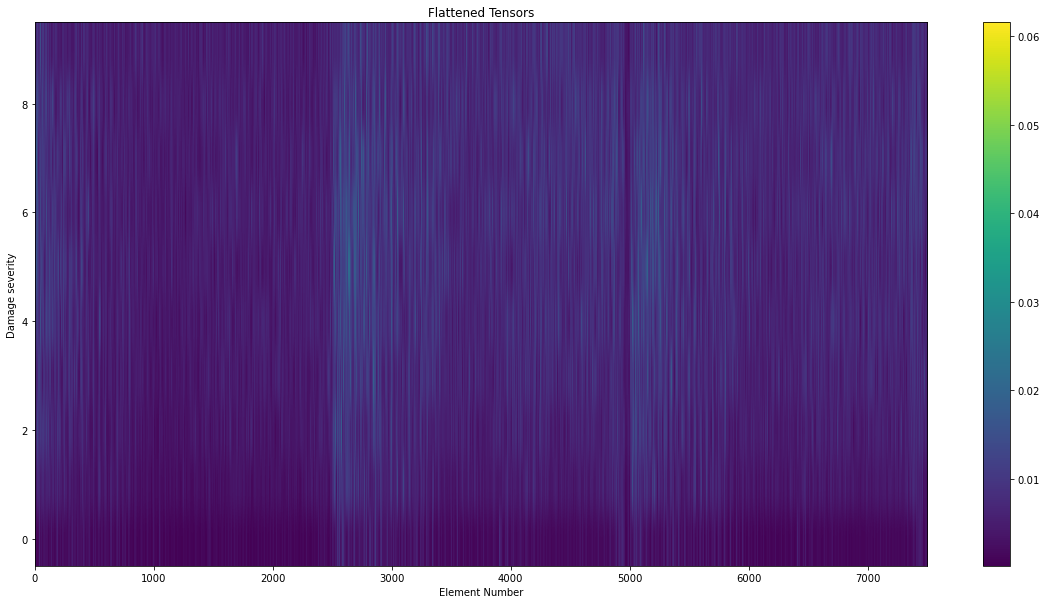

In [24]:
import torch
import matplotlib.pyplot as plt

# Step 1: Load the tensors from file A
tensor_list = []
for i in range(10):
    file_path = f"deepEmsemblesDataset/hidden_matrix_salt/hidden_img_std_{i}.pt"  # Update this with the correct file paths
    tensor = torch.load(file_path)[1,:] # torch.Size([64, 50, 50])
    tensor_list.append(tensor)

# Step 2: Flatten each tensor
flattened_tensors = [tensor.flatten() for tensor in tensor_list]
# print(flattened_tensors[0].shape) # torch.Size([160000])


# Step 3: Concatenate the flattened tensors into a single array
concatenated_img = torch.cat(flattened_tensors, dim=0)
# print(concatenated_array.shape) #torch.Size([1600000])
concatenated_img = concatenated_img.view(10, -1)
# Step 4: Plot the concatenated array as an image
plt.figure(figsize=(20, 10))

plt.imshow(concatenated_img.detach().numpy(), cmap='viridis', aspect='auto', origin='lower')

plt.colorbar()
plt.xlabel("Element Number")
plt.ylabel("Damage severity")
plt.title("Flattened Tensors")
# plt.yticks(range(10), range(10))  # Customize tick labels for the tensor sequence
plt.show()



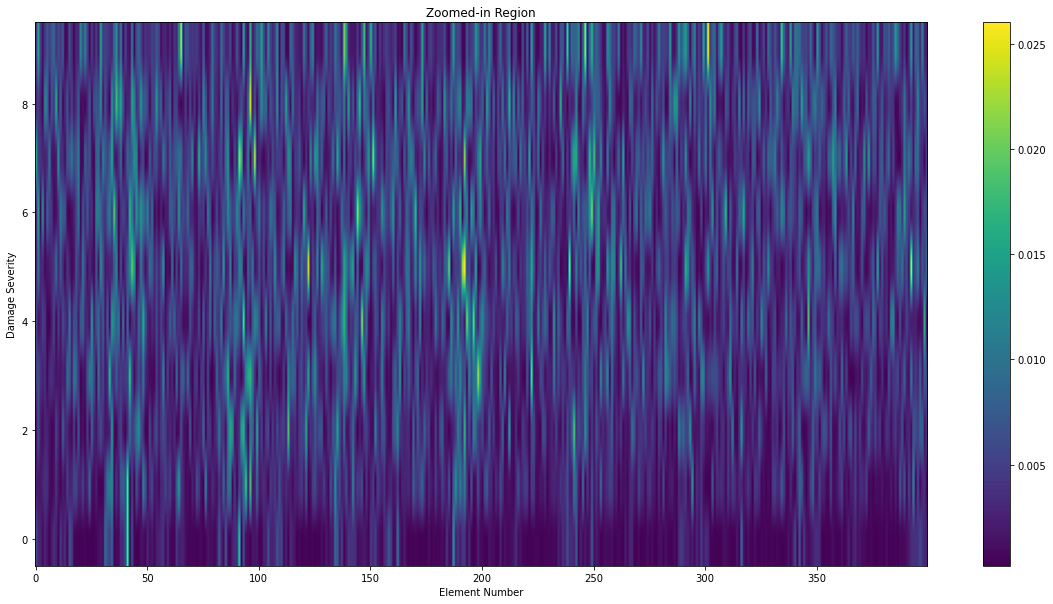

In [26]:
# Zoom in on another region (e.g., first 100 elements of tensor sequence 7)
plt.figure(figsize=(20, 10))
concatenated_img_zoom = concatenated_img.view(10, -1)[:,600:1000]
# print(concatenated_array_zoom.shape)
plt.imshow(concatenated_img_zoom.detach().numpy(), cmap='viridis', aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel("Element Number")
plt.ylabel("Damage Severity")
plt.title("Zoomed-in Region")

plt.show()

In [27]:
lidar_std_list = []
for i in range(10):
    file_path = f"deepEmsemblesDataset/hidden_matrix_salt/hidden_lidar_std_{i}.pt"  # Update this with the correct file paths
    lidar_std = torch.load(file_path)[1,:] # torch.Size([64, 50, 50])
    lidar_std_list.append(lidar_std)

# Step 2: Flatten each tensor
flattened_lidar_tensors = [tensor.flatten() for tensor in lidar_std_list]
# print(flattened_tensors[0].shape) # torch.Size([160000])


# Step 3: Concatenate the flattened tensors into a single array
concatenated_lidar = torch.cat(flattened_lidar_tensors, dim=0)
# print(concatenated_array.shape) #torch.Size([1600000])
concatenated_lidar = concatenated_lidar.view(10, -1)

print(concatenated_lidar.shape)

mean_std_lidar = torch.mean(concatenated_lidar, dim=1)
mean_std_img = torch.mean(concatenated_img, dim=1)


print(mean_std_img)
print(mean_std_lidar)

torch.Size([10, 7500])
tensor([0.0023, 0.0047, 0.0057, 0.0065, 0.0072, 0.0073, 0.0077, 0.0076, 0.0074,
        0.0070], grad_fn=<MeanBackward1>)
tensor([0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033,
        0.0033], grad_fn=<MeanBackward1>)


In [28]:
def P(std_img, std_lidar, k1, k2):
    
    delta = torch.log(k1*(std_lidar/std_img))*k2
    return delta

def fusion(delta, mean_img, mean_lidar):
    w1 = (torch.tanh(delta)+1)/2
    w2 = 1-w1
    decoder_input = w1*mean_img + w2*mean_lidar
    return decoder_input

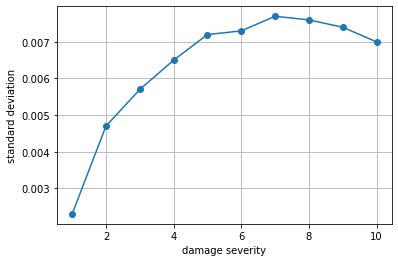

In [29]:

import torch

# Your tensor data
y_values = torch.tensor([0.0023, 0.0047, 0.0057, 0.0065, 0.0072, 0.0073, 0.0077, 0.0076, 0.0074, 0.0070])

# Create x-axis values as consecutive numbers starting from 1
x_values = torch.arange(1, len(y_values) + 1)

# Create the plot
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Add labels and a title
plt.xlabel('damage severity')
plt.ylabel('standard deviation')
plt.title('')

# Show the plot
plt.grid(True)
plt.show()

In [32]:
k1 = 2
k2 = 3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(3.2334, grad_fn=<MulBackward0>)
w1:0.9984482526779175,w2:0.0015517473220825195
tensor(1.0377, grad_fn=<MulBackward0>)
w1:0.8884814977645874,w2:0.1115185022354126
tensor(0.4410, grad_fn=<MulBackward0>)
w1:0.7072229385375977,w2:0.29277706146240234
tensor(0.0553, grad_fn=<MulBackward0>)
w1:0.5276092290878296,w2:0.4723907709121704
tensor(-0.2406, grad_fn=<MulBackward0>)
w1:0.3819577097892761,w2:0.6180422902107239
tensor(-0.2917, grad_fn=<MulBackward0>)
w1:0.35813671350479126,w2:0.6418632864952087
tensor(-0.4480, grad_fn=<MulBackward0>)
w1:0.28987759351730347,w2:0.7101224064826965


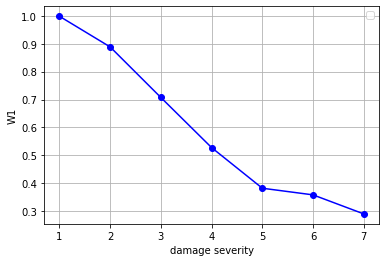

In [33]:

w1_list =[]

for i in range(7):
    std_lidar = mean_std_lidar[i]
    std_img = mean_std_img[i]
    delta = P(std_img, std_lidar, k1, k2)
    print(delta)
    w1 = (torch.tanh(delta)+1)/2
    w2 = 1-w1
    print(f'w1:{w1},w2:{w2}')
    w1_list.append(w1)


# Convert the delta_list to a NumPy array
numpy_array = torch.stack(w1_list).detach().numpy()

# Create the horizontal axis from 1 to 10
x_axis = range(1, 8)


# Plot the numpy array as line plots

plt.plot(x_axis, numpy_array, marker='o', linestyle='-', color='b')

# plt.plot(x_axis, numpy_array, marker='o', linestyle='-', label=f'{i+1}')
# plt.fill_between(x_axis, numpy_array[i], alpha=0.3)

plt.xlabel("damage severity")
plt.ylabel("W1")
plt.title("")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# mask

damage_severity = '6'
damaged_img_path = 'deepEmsemblesDataset/Mask/damaged_image_{}'.format(damage_severity) 


lidar_path = 'deepEmsemblesDataset/lidar_tensor'



label_path = 'deepEmsemblesDataset/ori_image'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))
lidar_list = sorted(glob.glob(lidar_path + '/*'))
label_list = sorted(glob.glob(label_path + '/*'))

learning_rate = 1e-4
batch_size = 32

TestDataset = CreateDatasets(label_list, damaged_img_list, lidar_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)


In [54]:
from sensorFusionNetwork.simpleAutoencoder import SimpleAutoencoder


i = 6
hidden_img_mean = torch.load(f"deepEmsemblesDataset/hidden_matrix_mask/hidden_img_mean_{i}.pt")  # Update this with the correct file paths
hidden_lidar_mean = torch.load(f"deepEmsemblesDataset/hidden_matrix_mask/hidden_lidar_mean_{i}.pt")


hidden_img_std = torch.load(f"deepEmsemblesDataset/hidden_matrix_mask/hidden_img_std_{i}.pt") 
hidden_lidar_std = torch.load(f"deepEmsemblesDataset/hidden_matrix_mask/hidden_lidar_std_{i}.pt")

delta = P(hidden_img_std, hidden_lidar_std, k1, k2)
decoder_input = fusion(delta, hidden_img_mean, hidden_lidar_mean)

# print(decoder_input.shape)


# mean_img = hidden_img_mean
# mean_lidar = hidden_lidar_mean
# decoder_input = w1*mean_img + w2*mean_lidar

print(decoder_input.shape)

decoder = SimpleAutoencoder()
decoder.load_state_dict(torch.load('model_save/fusion_5/ori2ori_1.pth'))
print(decoder)


removal_layer = nn.Sequential()
decoder.encoder = removal_layer
decoder.eval()

output = decoder(decoder_input)

# print(output.shape)

# print(torch.max(output[0]), torch.min(output[0]))


torch.Size([32, 64, 50, 50])
SimpleAutoencoder(
  (encoder): Encoder(
    (downconv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (downconv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (encoderBlock1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoderBlock2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (upconv1): Sequential(
      (0): ConvTranspose

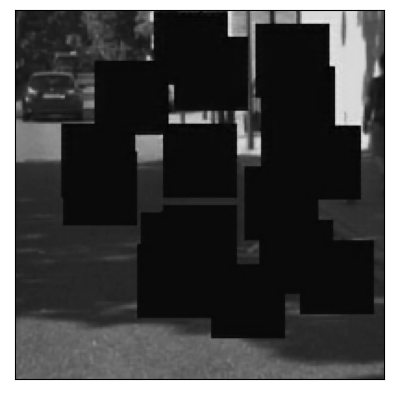

In [55]:
j =31
img4 = output[j].detach().numpy()
img4 = img4.transpose(1, 2, 0)

plt.xticks([])
plt.yticks([])
plt.imshow(img4, cmap='gray')
plt.savefig('fig_save/kk.png',bbox_inches = 'tight',transparent = True)

In [56]:
# MSE for all damages 注意 开头 damage severity 
criterion = nn.MSELoss()
criterion.to(device)
dataiter = iter(new_testloader)

count = 0

for i, batch in enumerate(new_testloader):# i -->index of batch
    count = 0
    label, damaged_img, lidar = next(dataiter)
    for j in range (batch_size):
        img1 = label[j]
        img2 = damaged_img[j]
        img3 = output[j]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,6)
    print(mse_mean)

3.763652


In [34]:
# salt

i = 4
hidden_img_mean = torch.load(f"deepEmsemblesDataset/hidden_matrix_salt/hidden_img_mean_{i}.pt")  # Update this with the correct file paths
hidden_lidar_mean = torch.load(f"deepEmsemblesDataset/hidden_matrix_salt/hidden_lidar_mean_{i}.pt")


hidden_img_std = torch.load(f"deepEmsemblesDataset/hidden_matrix_salt/hidden_img_std_{i}.pt") 
hidden_lidar_std = torch.load(f"deepEmsemblesDataset/hidden_matrix_salt/hidden_lidar_std_{i}.pt")

delta = P(hidden_img_std, hidden_lidar_std, k1, k2)
decoder_input = fusion(delta, hidden_img_mean, hidden_lidar_mean)

# print(decoder_input.shape)


# mean_img = hidden_img_mean
# mean_lidar = hidden_lidar_mean
# decoder_input = w1*mean_img + w2*mean_lidar

print(decoder_input.shape)

decoder = SimpleAutoencoder()
decoder.load_state_dict(torch.load('model_save/fusion_5/compressed_encoder/ori2ori_1.pth'))
print(decoder)


removal_layer = nn.Sequential()
decoder.encoder = removal_layer
decoder.eval()

output = decoder(decoder_input)

# print(output.shape)

# print(torch.max(output[0]), torch.min(output[0]))


torch.Size([32, 3, 50, 50])
SimpleAutoencoder(
  (encoder): Encoder(
    (downconv1): Sequential(
      (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (downconv2): Sequential(
      (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (encoderBlock1): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoderBlock2): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (upconv1): Sequential(
      (0): ConvTranspose2d(3, 3, ker

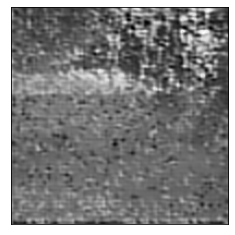

In [35]:
j =31
img4 = output[j].detach().numpy()
img4 = img4.transpose(1, 2, 0)

plt.xticks([])
plt.yticks([])
plt.imshow(img4, cmap='gray')
plt.savefig('fig_save/kk.png',bbox_inches = 'tight',transparent = True)

In [36]:
# MSE for all damages 注意 开头 damage severity 
criterion = nn.MSELoss()
criterion.to(device)
dataiter = iter(new_testloader)

count = 0

for i, batch in enumerate(new_testloader):# i -->index of batch
    count = 0
    label, damaged_img, lidar = next(dataiter)
    for j in range (batch_size):
        img1 = label[j]
        img2 = damaged_img[j]
        img3 = output[j]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,6)
    print(mse_mean)

1.740068


In [117]:
# # regional mse

# batch_size = 32

# def create_mask(image_shape, block_size, num_blocks):
#     mask = np.ones(image_shape, dtype=np.float32) 
#     block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
#     np.random.seed(6)

#     for _ in range(num_blocks):
#         top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
#         bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
#         mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
        
#     return mask


# block_size = 0.2  # 方块大小为原图大小的百分比
# num_blocks = 16  # 方块数量

# count = 0

# for j in range(label.size(0)):
#     ori_img_np = label[j][0].detach().numpy()
#     output_np = output[j][0].detach().numpy()
#     mask = create_mask(ori_img_np.shape[:2], block_size, num_blocks)
#     local_mse = np.mean(np.square(output_np - ori_img_np) * mask)
#     count = count+local_mse
# local_mse = round(count/batch_size, 6)

# print(local_mse)

In [9]:
import cv2
import os
import numpy

masked_region_list = []
original_image_list = []

image_path = 'testdataset/ori_image'
images = sorted(glob.glob(image_path + '/*'))[0:32]
damage_label = 'A'

def create_mask(image_shape, block_size, num_blocks):
    mask = np.ones(image_shape, dtype=np.float32) 
    block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
    np.random.seed(6)
    masked_region = []

    for _ in range(num_blocks):
        top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
        bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
        mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
        masked_region.append((top_left, bottom_right))
        
    return mask, masked_region


for i in range(len(images)):
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ori_img_name = os.path.basename(images[i])

    block_size = 0.2  # 方块大小为原图大小的百分比
    num_blocks = 16  # 方块数量
    mask, masked_region = create_mask(image.shape[:2], block_size, num_blocks)
    masked_region_list.append(masked_region)
    original_image_list.append(image)
    damaged_img1 = image * mask
    # cv2.imwrite(f'testdataset/damaged_image/{damage_label}_{ori_img_name}', damaged_img1)

regional_mse_list = []

for i in range(len(images)):
    original_image = original_image_list[i]
    masked_region = masked_region_list[i]
    original_image = (original_image-np.min(original_image))/(np.max(original_image)-np.min(original_image))
    

    
    # Obtain the output reconstructed image
    output_image = output[i][0].detach().numpy()  # Replace this with the code to get the output image from your image reconstruction network
    # output_image = (output_image-np.min(output_image))/(np.max(output_image)-np.min(output_image))
    
    mse = 0
    num_pixels = 0

    for region in masked_region:
        top_left, bottom_right = region
        original_pixels = original_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        output_pixels = output_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        diff = original_pixels.astype(np.float32) - output_pixels.astype(np.float32)
        mse += np.sum(diff ** 2)
        num_pixels += original_pixels.size

    mse /= num_pixels
    regional_mse_list.append(mse)

print(np.mean(regional_mse_list))

0.09524433820595732


In [10]:
# SSIM

import torch
from skimage.metrics import structural_similarity as ssim
import glob


metric_value_list = []
batch_size = 32


for i, batch in enumerate(new_testloader):
    label, damaged_img, lidar = batch
    count = 0
    for j in range(label.size(0)):
        ori_img_np = label[j][0].detach().cpu().numpy()
        output_np = output[j][0].detach().cpu().numpy()
        ssim_img, diff = ssim(ori_img_np, output_np, full=True, data_range=1.0)
        count = count + ssim_img
    ssim_img = round(count / label.size(0), 3)
    print(ssim_img)
#     metric_value_list.append(ssim_img)

# print(metric_value_list)

0.412
0.28
0.266
0.254
0.234
0.257
0.262
0.253


In [11]:
# LLIPS metrics

import lpips

loss_fn = lpips.LPIPS(net='alex')


for i, batch in enumerate(new_testloader):  # i -->index of batch
    label, damaged_img, lidar = batch
    count = 0
    for j in range(label.size(0)):
        # ori_img_np = ori_img[j][0].detach().numpy()
        # output_np = output[j][0].detach().numpy()
        lpips_img = loss_fn.forward(label, output)
        sum_result = (torch.sum(lpips_img)).item()
        count = count+sum_result
        # count = count.item()
    lpips_img = round(count/label.size(0),3)
    print(lpips_img)
#     metric_value_list.append(lpips_img)

# print(f'scuccess: {metric_value_list}')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/Anaconda3-2021.11-Linux-x86_64/envs/pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
16.545


KeyboardInterrupt: 

In [ ]:
# resnet 50 evaluation
import torch
import torch.nn as nn
import torchvision.models as models

# 加载预训练的ResNet-50模型
resnet = models.resnet50(pretrained=True)

# 替换最后一层全连接层
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)  # 输出为1维

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# 训练回归模型
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss))
    print('Training finished.')

# 定义数据集和数据加载器
# 这里假设您已经准备好了您的数据集并将其转换为PyTorch Dataset格式
dataset = MyDataset(...)  # 替换为您的数据集
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# 调用训练函数进行模型训练
train(resnet, train_loader, criterion, optimizer, num_epochs=10)

# 评估模型并输出还原程度的度量值
def evaluate(model, test_loader):
    model.eval()
    metric_values = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            metric_values.extend(outputs.flatten().tolist())
    return metric_values

# 定义测试数据集和数据加载器
# 这里假设您已经准备好了测试数据集并将其转换为PyTorch Dataset格式
test_dataset = MyDataset(...)  # 替换为您的测试数据集
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 调用评估函数获取还原程度的度量值
metric_values = evaluate(resnet, test_loader)

# metric_values包含了输入经过reconstruction的受损图的还原程度度量值
print(metric_values)
